In [5]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt

file_path = ["R Processed Data/BB_imp_sc_trans_filt_label.csv", 
             "R Processed Data/HMP_imp_sc_trans_filt_label.csv", 
             "R Processed Data/BB_HMPcommon_imp_sc_trans_label.csv",
             "R Processed Data/HMP_BBcommon_imp_sc_trans_label.csv"]

file_name = ["All UK Biobank",
             "All HMP2 IBDMDB",
             "Common UK Biobank",
             "Common HMP2 IBDMDB"]

X_list = []
y_list = []
X_outer_train = []
y_outer_train = []
X_outer_test = []
y_outer_test = []

for dataset_id in range(len(file_path)):
    X_data = pd.read_csv(file_path[dataset_id], index_col=0).sort_index()
    X_list.append(X_data)
    y_data = X_data['Label']
    y_list.append(y_data)
    y_list[dataset_id] = y_list[dataset_id].replace({'IBD': 1, 'nonIBD': 0})
    X_list[dataset_id] = X_data.drop('Label', axis=1)
    
    # Leave out 20% for external testing and final model evaluation
    X_inner, X_outer, y_inner, y_outer = train_test_split(X_list[dataset_id], y_list[dataset_id], test_size=0.2,
                                                          stratify=y_list[dataset_id], random_state=42)

    X_outer_train.append(X_inner)
    y_outer_train.append(y_inner)
    X_outer_test.append(X_outer)
    y_outer_test.append(y_outer)

In [2]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

TOTAL_TREES = 1000
FOLDS = 5
REPEATS = 5 # for repeating through each combination of test-train split 
# for testing how each 1000 tree model performs repeatedly (REPEATS times) for each 5 skf

base_model = RandomForestClassifier(n_estimators=TOTAL_TREES, random_state=42, n_jobs=-1)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
classifier = []
fpr = []
tpr = []
auc_score = []
X_test = []
y_test = []

for dataset_id in range(len(file_path)):  # iterate over all datasets
    print(file_name[dataset_id])
    X_train, y_train = X_outer_train[dataset_id], y_outer_train[dataset_id]  # get the data
    
    # Set up param_grid based on dataset_id
    if dataset_id == 0 or dataset_id == 2:
        criterion_values = ['gini']
    else:
        criterion_values = ['entropy']
    
    param_grid = {
        'max_samples': [0.5, 0.8], 
        'max_features': ['sqrt', 0.3, 0.5, None],
        'max_depth': [5, 10, 20, 30], 
        'criterion': criterion_values
    }
    
    best_grid_model_repeat = []
    
    for repeat in range(REPEATS):
        print(dataset_id, repeat)
        train_indices, test_indices = train_test_split(X_train.index, shuffle = True, test_size = 0.3, random_state=repeat)
        X_inner_train = X_train.loc[train_indices]
        y_inner_train = y_train.loc[train_indices]
        X_inner_test = X_train.loc[test_indices]
        y_inner_test = y_train.loc[test_indices]

        grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                                   scoring=make_scorer(roc_auc_score, needs_threshold=True), 
                                   cv=skf, n_jobs=-1)
        grid_search.fit(X_inner_train.values, y_inner_train)
        best_grid_model = grid_search.best_estimator_
        
        y_inner_pred_prob = None
        score_rocauc = []
        max_rocauc = 0
        
        # Loop through every tree in a repeat fold and calculate the average ROC AUC scores for each cv fold within it
        for count, estimator in enumerate(best_grid_model.estimators_):
            cv_score = cross_val_score(estimator, X_inner_train.values, y_inner_train, 
                                       scoring=make_scorer(roc_auc_score, needs_threshold=True), cv = skf)
            avg_cv_score = sum(cv_score)/FOLDS
            score_rocauc.append(avg_cv_score)
            if score_rocauc[count] > max_rocauc:
                max_rocauc = score_rocauc[count]
                best_tree_num = count + 1   
            
        best_grid_model.estimators_ = best_grid_model.estimators_[:best_tree_num]
        print("max rocauc from cv per estimator: ", max_rocauc)
        print("best tree num from cv per estimator: ", best_tree_num)
        
        # Store the results for this repeat
        best_grid_model_repeat.append([max_rocauc, best_grid_model, best_tree_num])
        best_grid_model_repeat.sort(reverse = True)
    
    # Find the sublist with the maximum max_rocauc
    best_repeat_model = best_grid_model_repeat[0][1]
    params = best_repeat_model.get_params()
    params['n_estimators'] = best_grid_model_repeat[0][2]
    best_repeat_model = RandomForestClassifier(**params)
    classifier.append(best_repeat_model.fit(X_train.values, y_train))

    X_test.append(X_outer_test[dataset_id])
    y_test.append(y_outer_test[dataset_id])
    
    y_pred_prob = classifier[dataset_id].predict_proba(X_test[dataset_id].values)[:, 1]
    fpr_num, tpr_num, _ = roc_curve(y_test[dataset_id], y_pred_prob)
    auc_score_num = auc(fpr_num, tpr_num)
    fpr.append(fpr_num)
    tpr.append(tpr_num)
    auc_score.append(auc_score_num)
    
    print("ROC AUC SCORE FOR ALL REPEAT FOLDS\n", best_grid_model_repeat)
    print("FINAL OPTIMIZED MODEL\n:", classifier[dataset_id])
    print("AUC ROC SCORE\n", auc_score_num)
    print()

All UK Biobank
0 0
max rocauc from cv per estimator:  0.5737144173211022
best tree num from cv per estimator:  746
0 1
max rocauc from cv per estimator:  0.5781067855398395
best tree num from cv per estimator:  792
0 2
max rocauc from cv per estimator:  0.6006051071591427
best tree num from cv per estimator:  849
0 3
max rocauc from cv per estimator:  0.5600081823644476
best tree num from cv per estimator:  265
0 4
max rocauc from cv per estimator:  0.5703879486291621
best tree num from cv per estimator:  647
ROC AUC SCORE FOR ALL REPEAT FOLDS
 [[0.6006051071591427, RandomForestClassifier(max_depth=5, max_features=0.3, max_samples=0.8,
                       n_estimators=1000, n_jobs=-1, random_state=42), 849], [0.5781067855398395, RandomForestClassifier(max_depth=10, max_features=0.3, max_samples=0.8,
                       n_estimators=1000, n_jobs=-1, random_state=42), 792], [0.5737144173211022, RandomForestClassifier(max_depth=5, max_features=None, max_samples=0.5,
                

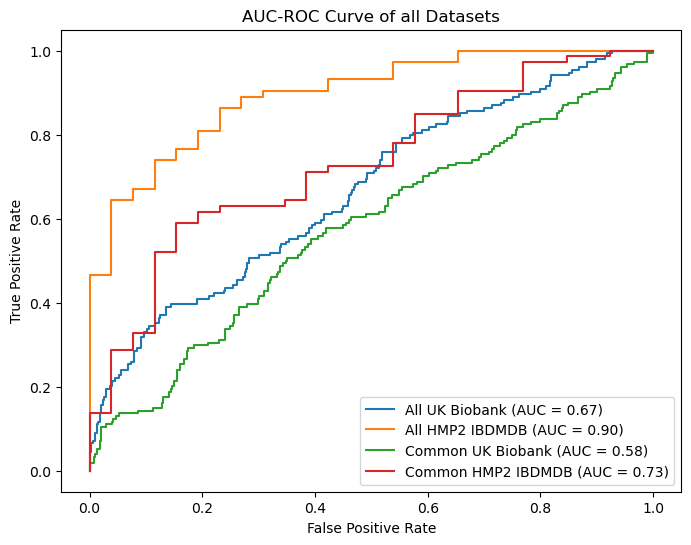

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
for i in range(len(file_path)):
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(file_name[i], auc_score[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve of all Datasets')
plt.legend()
plt.savefig('Machine Learning & Explainable AI/AUC-ROC Curve of all Datasets.png')
plt.show()

In [4]:
explainer = [i for i in range(len(file_path))]
shap_values = [i for i in range(len(file_path))]
shap_values_df = [i for i in range(len(file_path))]

In [5]:
import shapmat
import shap
from shapmat.explainer import Explainer

# Calculate SHAP values
for i in range(len(file_path)):
    explainer[i] = Explainer(X = X_test[i], y = y_test[i], model = classifier[i])
    shap_values[i] = explainer[i].shap()
    shap_values_df[i] = explainer[i].shap_df(filter_zero_column = True,
                                                correct_pred_only = True)

 99%|===================| 1064/1072 [00:32<00:00]        X has feature names, but RandomForestClassifier was fitted without feature names


Number of features with nonzero mean(|SHAP|): 36/36


X has feature names, but RandomForestClassifier was fitted without feature names


Number of features with nonzero mean(|SHAP|): 161/161


100%|===================| 1070/1072 [02:24<00:00]        X has feature names, but RandomForestClassifier was fitted without feature names


Number of features with nonzero mean(|SHAP|): 10/10
Number of features with nonzero mean(|SHAP|): 10/10


X has feature names, but RandomForestClassifier was fitted without feature names


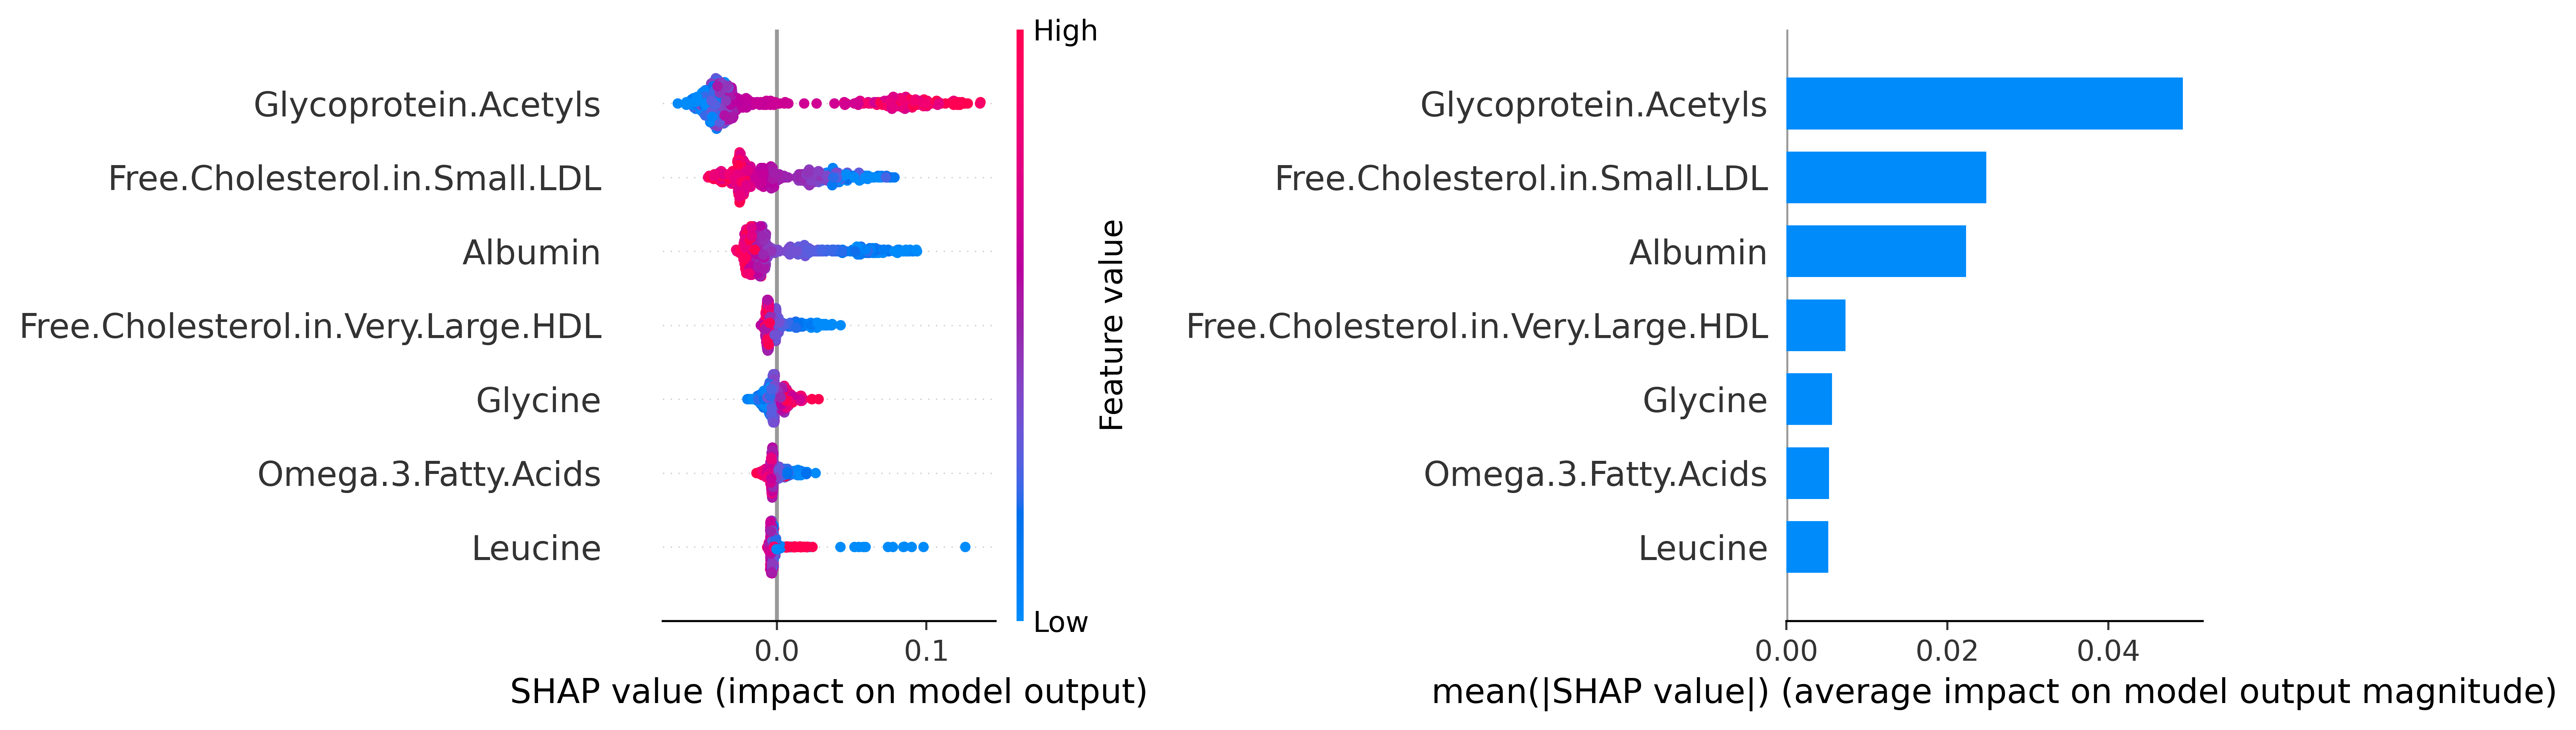

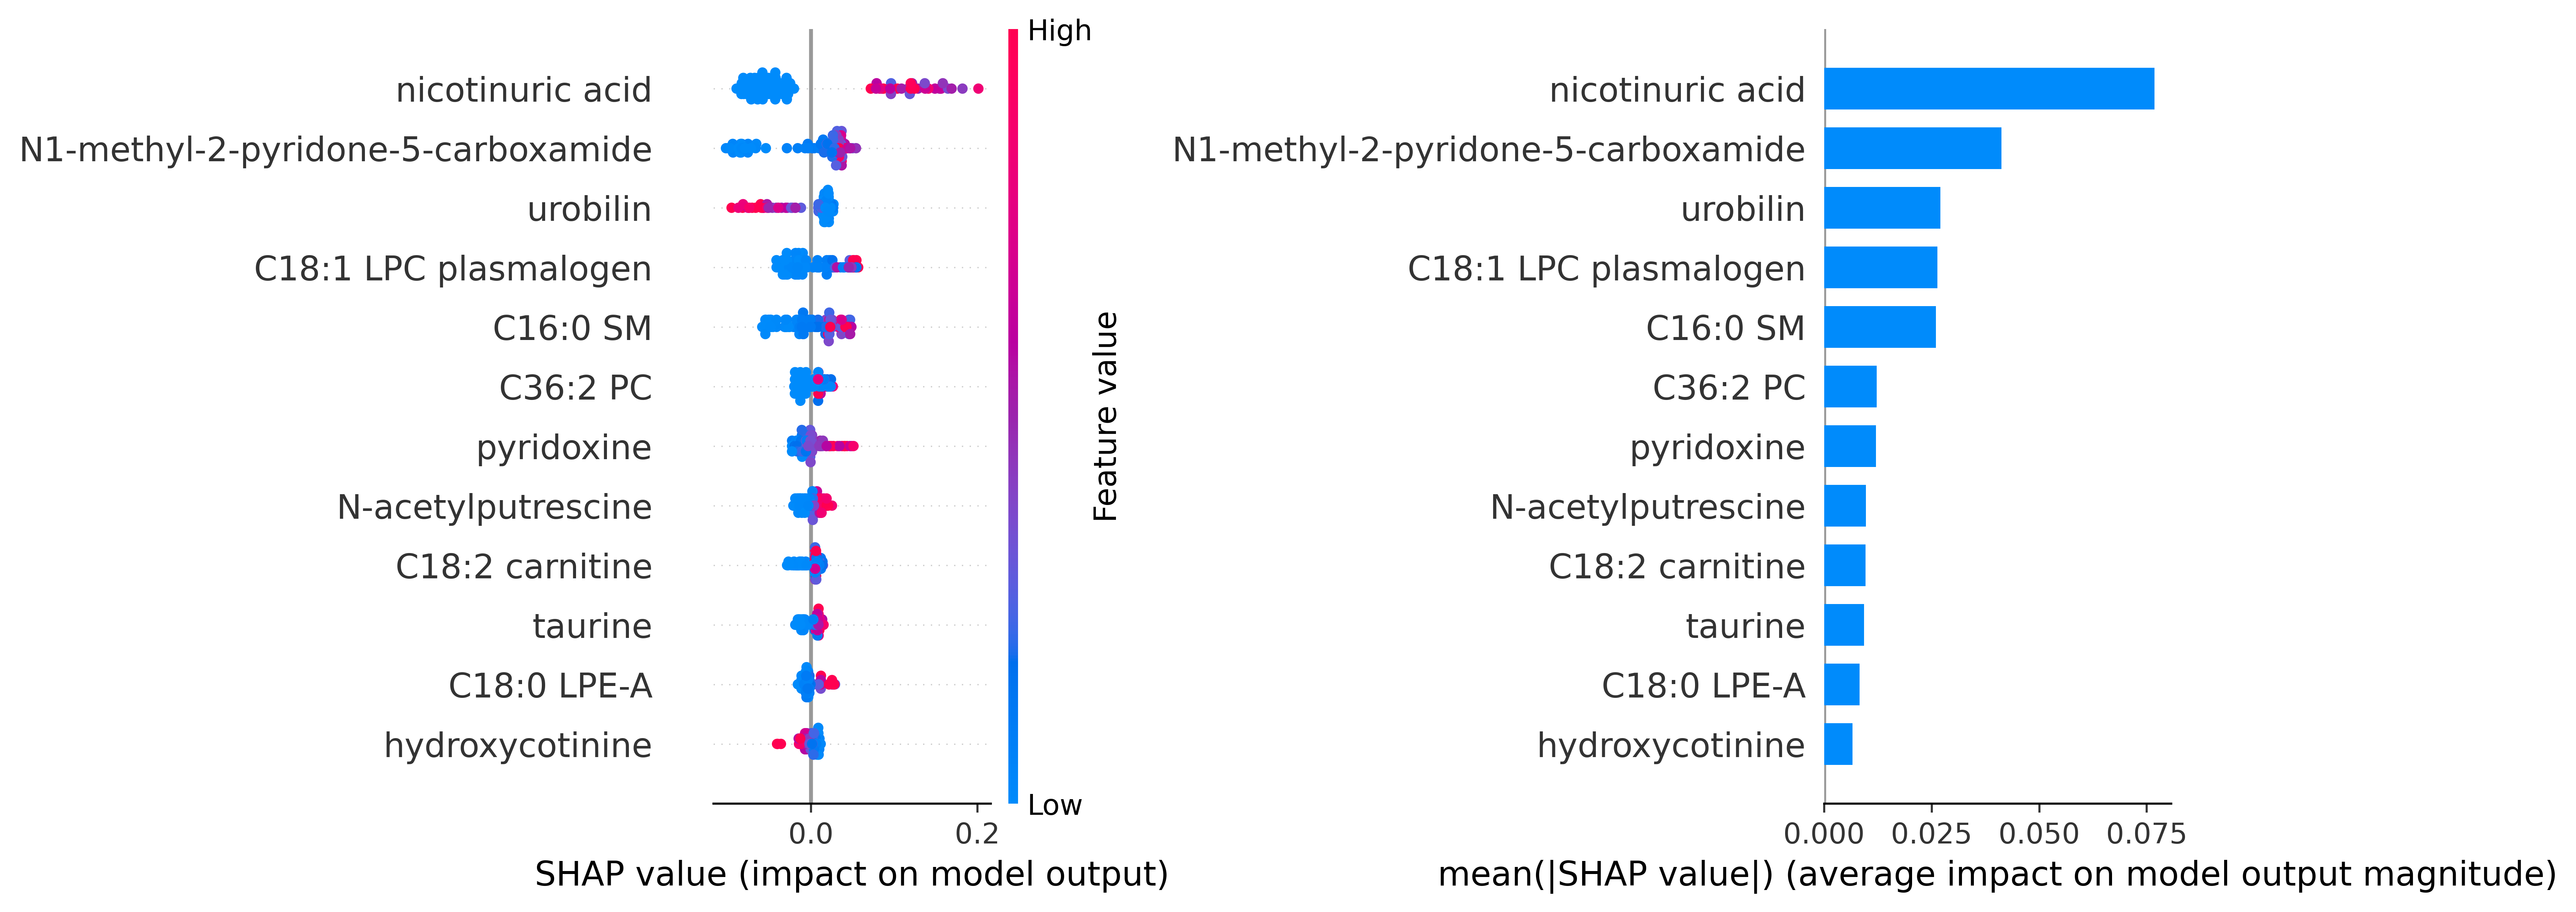

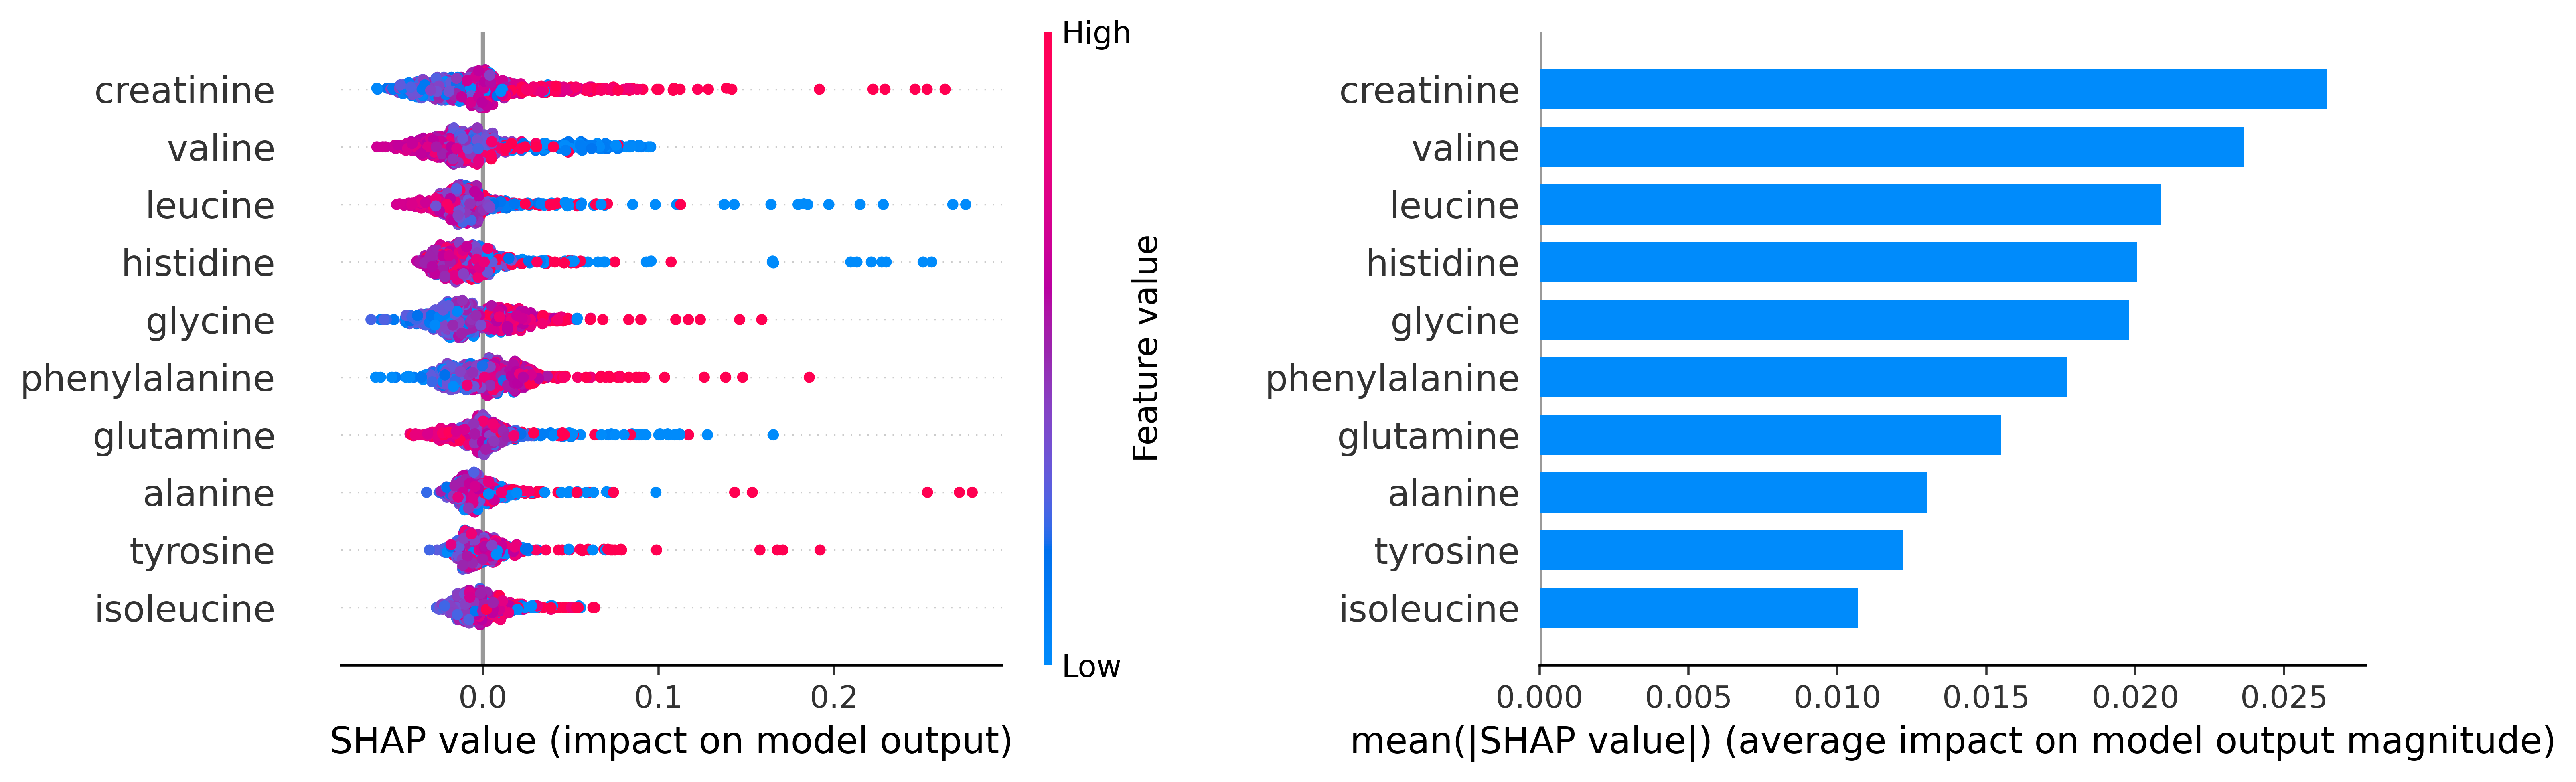

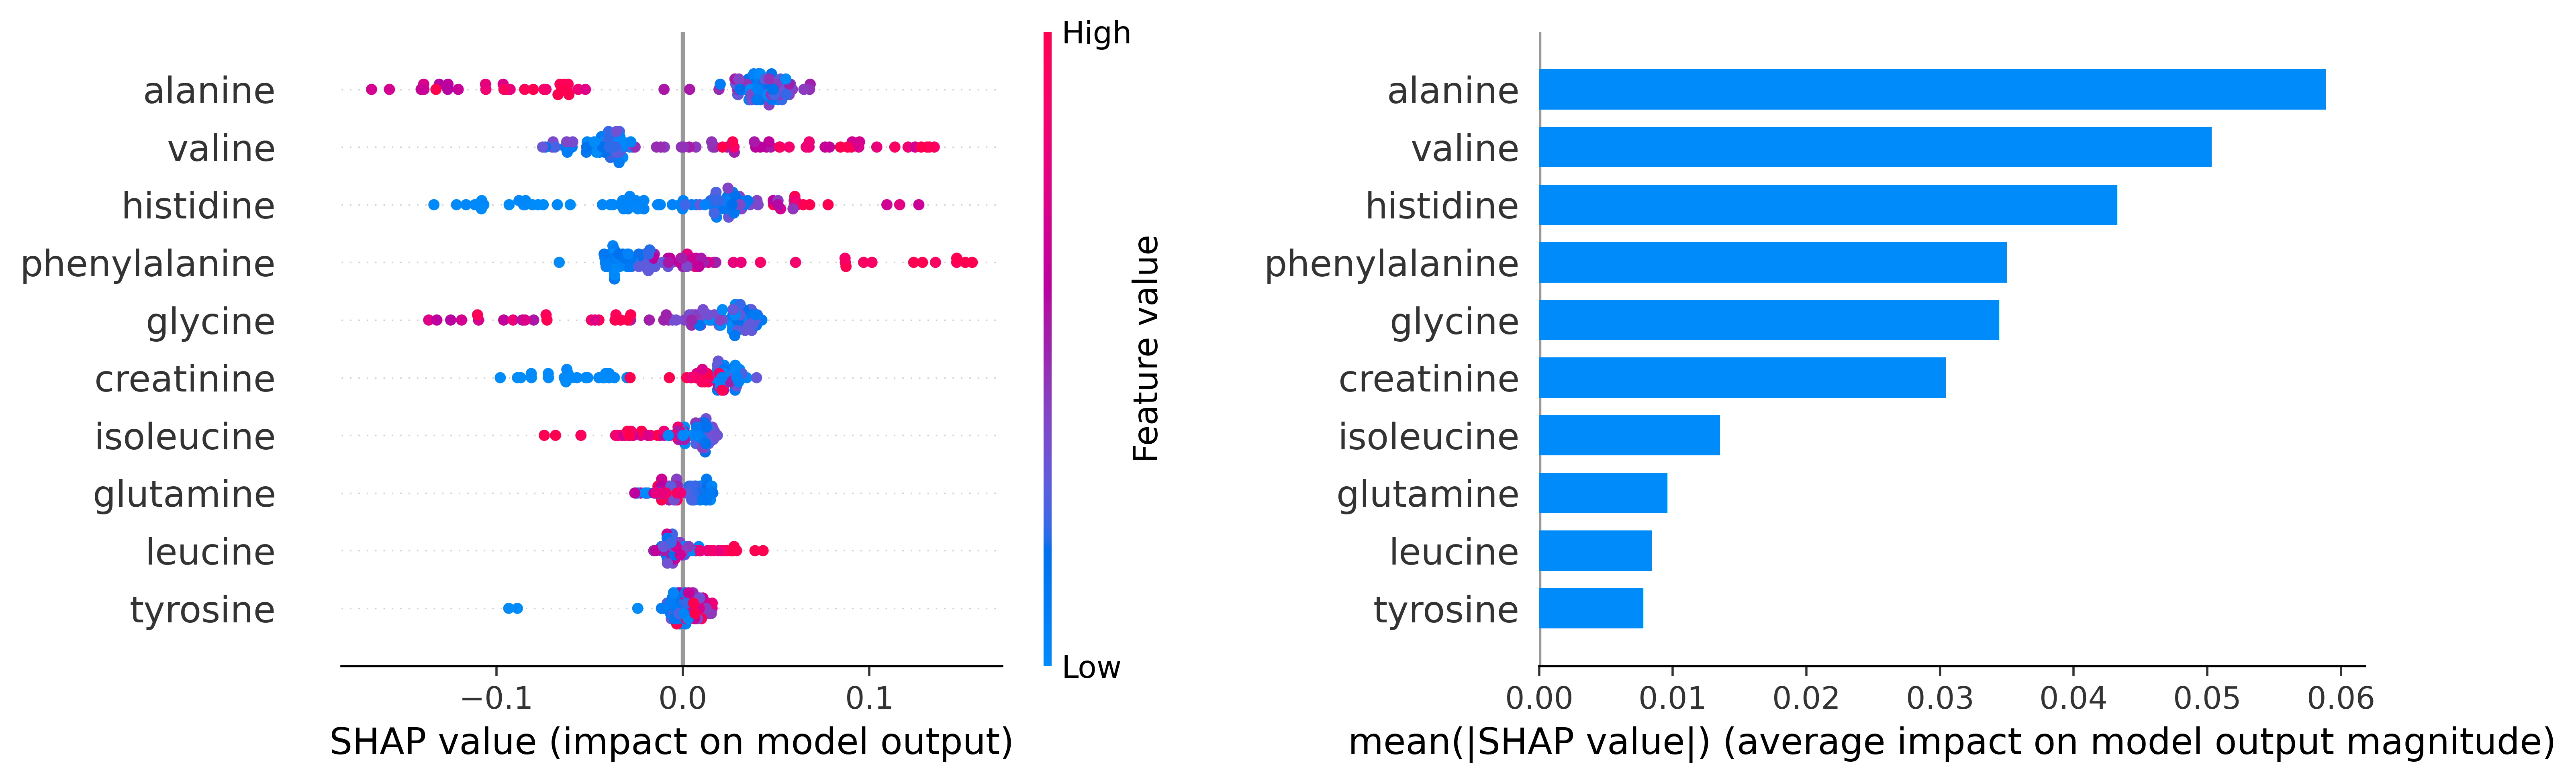

In [10]:
from shapmat.shap_plot import summary_plot
import shap
import numpy as np

for i in range(len(file_name)):
    
    # Calculate the mean of absolute values for each column
    abs_mean_values = np.abs(shap_values_df[i]).mean()
    ranked_metabolites = abs_mean_values
    # select only the features that have at least 0.5% impact on model output
    selected_columns = int(len(abs_mean_values[abs_mean_values > 0.005]))
    
    if i == 0:
        w = 1.7
        l = 12
        h = 4
    elif i == 1:
        w = 2.2 # space in between both plots
        l = 12
        h = 5
    else:
        w = 0.45
        l = 12
        h = 4
        
    # Create a figure with subplots
    fig = plt.figure(figsize=(l, h), dpi=500)
    
    # Plot the first graph
    ax1 = fig.add_subplot(1, 2, 1)
    summary_plot(shap_values[i], X_test[i], max_display= selected_columns)
    # Plot the second graph
    ax2 = fig.add_subplot(1, 2, 2)
    shap.summary_plot( shap_values[i], X_test[i], show=False, plot_size=None, max_display=selected_columns, plot_type='bar')
    # Adjust the spacing between subplots
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=w)
    # Save the figure
    plt.savefig('Machine Learning & Explainable AI/{}_summary_mean.png'.format(file_name[i]), bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Export the ranked metabolites:
    pd.concat([y_list[i], X_list[i][abs_mean_values.sort_values(ascending=False).index]], axis = 1).to_csv(f"../Machine Learning & Explainable AI/Metabolomics/Shap Ranked for {file_name[i]}.csv", index = True)

In [7]:
%store classifier
%store fpr 
%store tpr
%store auc_score
%store X_test
%store y_test
%store explainer
%store shap_values
%store shap_values_df

Stored 'classifier' (list)
Stored 'fpr' (list)
Stored 'tpr' (list)
Stored 'auc_score' (list)
Stored 'X_test' (list)
Stored 'y_test' (list)
Stored 'explainer' (list)
Stored 'shap_values' (list)
Stored 'shap_values_df' (list)
